In [1]:
import numpy as np
import pandas as pd

from sklearnex import patch_sklearn
patch_sklearn()

import sklearn as sklearn
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator,ClassifierMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import random
import gc



DEBUG = 'DEBUG'

import tensorflow as tf
from tensorflow import keras
import gc

from tensorflow.keras import Sequential, layers, losses
from tensorflow.keras.models import Model
#from tensorflow.keras.datasets import fashion_mnist
from tqdm.keras import TqdmCallback

DEBUG = 'DEBUG: '

tf.keras.backend.clear_session()
gc.collect()

def disable_gpu_tf():
  try:
      # Disable all GPUS
      tf.config.set_visible_devices([], 'GPU')
      visible_devices = tf.config.get_visible_devices()
      for device in visible_devices:
        print(DEBUG,visible_devices)
        assert device.device_type != 'GPU'
  except:
      # Invalid device or cannot modify virtual devices once initialized.
      pass

#print(DEBUG,tf.__version__)
print(DEBUG,tf.config.get_visible_devices())
#disable_gpu_tf()



np.__version__,pd.__version__,sklearn.__version__,tf.__version__

d:\ProgramData\Miniconda3\envs\ppcompts\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DEBUG:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


('1.22.3', '1.4.2', '1.0.2', '2.6.0')

In [2]:
import os, shutil, pathlib

original_dir = '../../data/dogs-vs-cats/train'
new_basedir = '../data'

def make_subset(subset_name,start_index, end_index):
  for category in ('cat','dog'):
    dir = f"{new_basedir}/{subset_name}/{category}"
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in range(start_index,end_index)]
    for fname in fnames:
      shutil.copyfile(src=f"{original_dir}/{fname}",dst=f"{dir}/{fname}")

In [3]:
def plotHistory(history_,yscale='linear',bfilter=1):
    plt.plot(history_["loss"][bfilter:], label="Training Loss")
    plt.yscale(yscale)
    try: 
      plt.plot(history_["val_loss"][bfilter:], label="Validation Loss")
      plt.yscale(yscale)
    except: pass
    plt.legend()
    plt.show()

In [5]:
tf.keras.backend.clear_session()
gc.collect()

conv_base = tf.keras.applications.vgg16.VGG16(weights='imagenet',include_top=False)
conv_base.trainable = False
inputs = tf.keras.Input(shape=(180,180,3))

x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1,activation='sigmoid')(x)
model = tf.keras.Model(inputs=inputs,outputs=outputs)
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 180, 180, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               3277056   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0     

In [6]:
%%time
from tensorflow.keras.utils import image_dataset_from_directory
import datetime

train_dataset = image_dataset_from_directory(f"{new_basedir}/train",image_size=(180,180),batch_size=32)
validation_dataset = image_dataset_from_directory(f"{new_basedir}/validation",image_size=(180,180),batch_size=32)
test_dataset = image_dataset_from_directory(f"{new_basedir}/test",image_size=(180,180),batch_size=32)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [
  tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)
  ,tf.keras.callbacks.ModelCheckpoint(filepath='modelo2.keras',save_best_only=True,monitor="val_loss")
  ,TqdmCallback()
  ]

history = model.fit(train_dataset,epochs=1000,validation_data=validation_dataset,verbose=0,callbacks=callbacks)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


  4%|▎         | 37/1000 [07:18<3:10:03, 11.84s/epoch, loss=1.79e-24, accuracy=1, val_loss=6.17, val_accuracy=0.977]   


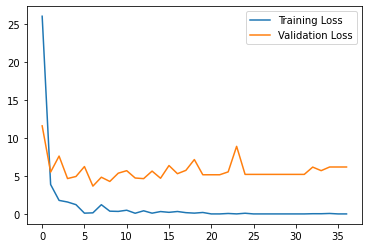

In [9]:
plotHistory(history.history,bfilter=0)

In [10]:
model.evaluate(test_dataset)

63/63 [==============================] - 17s 229ms/step - loss: 7.3395 - accuracy: 0.9695


[7.3394975662231445, 0.9695000052452087]

In [4]:
tf.keras.backend.clear_session()
gc.collect()

data_agumentation= tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal')
  ,layers.experimental.preprocessing.RandomRotation(0.1)
  ,layers.experimental.preprocessing.RandomZoom(0.2)
  ,layers.experimental.preprocessing.RandomContrast(0.1)
])

conv_base = tf.keras.applications.vgg16.VGG16(weights='imagenet',include_top=False)
conv_base.trainable = False
inputs = tf.keras.Input(shape=(180,180,3))

x = data_agumentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1,activation='sigmoid')(x)
model = tf.keras.Model(inputs=inputs,outputs=outputs)
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 180, 180, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               163852

In [5]:
%%time
from tensorflow.keras.utils import image_dataset_from_directory
import datetime

train_dataset = image_dataset_from_directory(f"{new_basedir}/train",image_size=(180,180),batch_size=32)
validation_dataset = image_dataset_from_directory(f"{new_basedir}/validation",image_size=(180,180),batch_size=32)
test_dataset = image_dataset_from_directory(f"{new_basedir}/test",image_size=(180,180),batch_size=32)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [
  tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)
  ,tf.keras.callbacks.ModelCheckpoint(filepath='modelo2.keras',save_best_only=True,monitor="val_loss")
  ,tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,patience=5, min_lr=0.0001)
  ,TqdmCallback()
  ]

history = model.fit(train_dataset,epochs=1000,validation_data=validation_dataset,verbose=0,callbacks=callbacks,use_multiprocessing=True)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


 21%|██        | 211/1000 [42:15<2:38:00, 12.02s/epoch, loss=0.00474, accuracy=0.999, val_loss=0.308, val_accuracy=0.982, lr=1e-04]    

CPU times: total: 1h 12min 49s
Wall time: 42min 16s


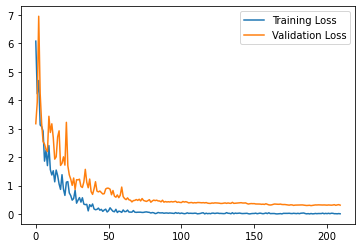

In [6]:
plotHistory(history.history)

In [7]:
model.evaluate(test_dataset)

63/63 [==============================] - 18s 244ms/step - loss: 0.4638 - accuracy: 0.9785


[0.4637700021266937, 0.9785000085830688]

In [982]:
tf.keras.backend.clear_session()
gc.collect()

class RandomGrayscale(layers.Layer):
  def __init__(self, factor=0.5,**kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    if np.random.uniform()<self.factor:
      ret = tf.image.grayscale_to_rgb(tf.image.rgb_to_grayscale(x))
    else:
      ret = tf.image.random_brightness(x, self.factor)
    return ret

  def get_config(self):
      config = super().get_config().copy()
      config.update({
          'factor': self.factor,
      })
      return config

class RandomBrightness(layers.Layer):
  def __init__(self, factor=0.5,**kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    #print(DEBUG,"OI")
    ret = tf.image.random_brightness(x, self.factor)
    return ret

  def get_config(self):
      config = super().get_config().copy()
      config.update({
          'factor': self.factor,
      })
      return config

data_agumentation = tf.keras.Sequential([
  RandomBrightness(0.2)
  ,layers.experimental.preprocessing.RandomFlip('horizontal')
  ,layers.experimental.preprocessing.RandomRotation(0.1)
  ,layers.experimental.preprocessing.RandomZoom(0.2)
  ,RandomGrayscale(0.2)
])

conv_base = tf.keras.applications.vgg16.VGG16(weights='imagenet',include_top=False)
conv_base.trainable = False
for l in conv_base.layers[:-2]:
  l.trainable = False

inputs = tf.keras.Input(shape=(180,180,3))

x = data_agumentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1,activation='sigmoid')(x)
model = tf.keras.Model(inputs=inputs,outputs=outputs)
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 180, 180, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dropout (Dropout)            (None, 12800)             0     

In [652]:
from tensorflow.keras.utils import image_dataset_from_directory
import datetime

train_dataset = image_dataset_from_directory(f"{new_basedir}/train",image_size=(180,180),batch_size=64)
validation_dataset = image_dataset_from_directory(f"{new_basedir}/validation",image_size=(180,180),batch_size=64)
test_dataset = image_dataset_from_directory(f"{new_basedir}/test",image_size=(180,180),batch_size=64)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [
  tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)
  ,tf.keras.callbacks.ModelCheckpoint(filepath='modelo3.keras',save_best_only=True,monitor="val_loss")
  ,tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,patience=4, min_lr=1e-5)
  ,TqdmCallback()
  ]

history = model.fit(train_dataset,epochs=1000,validation_data=validation_dataset,verbose=0,callbacks=callbacks,use_multiprocessing=True)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


  9%|▉         | 91/1000 [17:04<2:50:33, 11.26s/epoch, loss=0.0271, accuracy=0.994, val_loss=0.143, val_accuracy=0.986, lr=5.5e-5]   


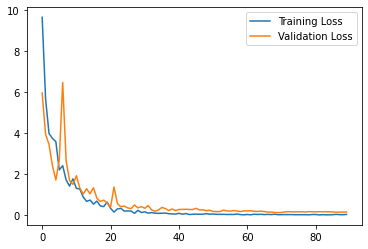

In [653]:
plotHistory(history.history)

In [654]:
model.evaluate(test_dataset)

32/32 [==============================] - 8s 216ms/step - loss: 0.1490 - accuracy: 0.9785


[0.14895038306713104, 0.9785000085830688]

In [655]:
import pathlib
import os
import PIL
import PIL.Image

data_dir = pathlib.Path(f"{new_basedir}/test")

DEBUG:  Predict: CATS 0 <--> 100 DOGS :::  100


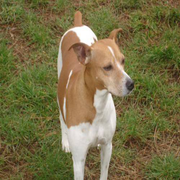

In [1018]:
dogs = list(data_dir.glob('dog/*.jpg'))
cats = list(data_dir.glob('cat/*.jpg'))
origimg = PIL.Image.open(str(dogs[np.random.choice(range(len(dogs)))])).convert('RGB') 
resizeimg = origimg.resize((180,180),PIL.Image.Resampling.LANCZOS)
img = np.array(resizeimg)

print(DEBUG,"Predict: CATS 0 <--> 100 DOGS ::: ", int(100*model.predict(img.reshape(1,*img.shape))[0][0]))

PIL.Image.fromarray(np.array(img))

(180, 180, 3)
DEBUG:  Predict: CATS 0 <--> 100 DOGS :::  100


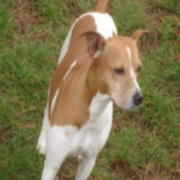

In [1019]:

img_agum = data_agumentation(img.reshape(1,*img.shape))[0]
#img_agum = RandomBrightness(0.8)(img.reshape(1,*img.shape))[0]
print(np.array(img_agum).shape)
print(DEBUG,"Predict: CATS 0 <--> 100 DOGS ::: ",int(100*model.predict(np.array(img_agum).astype('uint8').reshape(1,*img.shape))[0][0]))
PIL.Image.fromarray(np.array(img_agum).astype('uint8'))

